In [43]:
# Importing libraries for data handling
import pandas as pd
import numpy as np
import scipy.stats
from scipy.spatial.distance import pdist, squareform

# Importing library for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Importing function for machine learning
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

# Importing functions for model evaluation
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import average_precision_score, ndcg_score

In [44]:
# Set filenames
movies_filename = '/kaggle/input/movieproject/movies.dat'
ratings_filename = '/kaggle/input/movieproject/ratings.dat'
users_filename = '/kaggle/input/movieproject/users.dat'

In [45]:
# Read data from the given files

df_movies = pd.read_csv(
    movies_filename,
    delimiter='::',
    header=None,
    names=['movieId', 'title', 'genres'],
    dtype={'movieId': 'int32', 'title': 'str', 'genres': 'str'},
    engine='python',
    encoding='ISO-8859-1'
)

df_ratings = pd.read_csv(
    ratings_filename,
    delimiter='::',
    header=None,
    names=['userId', 'movieId', 'rating', 'timestamp'],
    usecols=[0, 1, 2],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'},
    engine='python',
    encoding='ascii'
)

df_users = pd.read_csv(
    users_filename,
    delimiter='::',
    header=None,
    names=['userId', 'gender', 'age', 'occupation', 'zip-code'],
    dtype={'userId': 'int32', 'gender': 'str', 'age': 'int32', 
           'occupation': 'int32', 'zip-code': 'str'},
    engine='python',
    encoding='ascii'
)

In [46]:
# Display movies dataset
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [47]:
# Display ratings dataset
df_ratings.head()

,userId,movieId,rating
0,1,1193,5.0
1,1,661,3.0
2,1,914,3.0
3,1,3408,4.0
4,1,2355,5.0


In [48]:
# Display users dataset
df_users.head()

,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


# Exploratory Data Analysis

In [49]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   userId   1000209 non-null  int32  
 1   movieId  1000209 non-null  int32  
 2   rating   1000209 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 11.4 MB


In [50]:
# Merging the ratings and movies datasets on the 'movieId' column
df = pd.merge(df_ratings, df_movies, on='movieId', how='inner')

# Displaying the merged dataset
df.head()

,userId,movieId,rating,title,genres
0,1,1193,5.0,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5.0,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4.0,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4.0,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5.0,One Flew Over the Cuckoo's Nest (1975),Drama


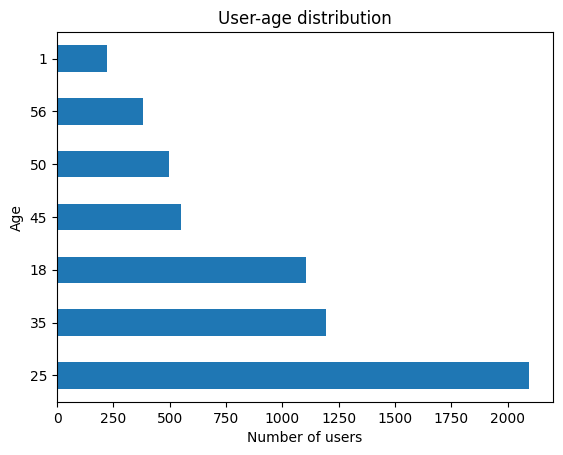

In [51]:
# Visualize user age distribution
df_users['age'].value_counts().plot(kind='barh')
plt.title('User-age distribution')
plt.ylabel('Age')
plt.xlabel('Number of users')
plt.show()

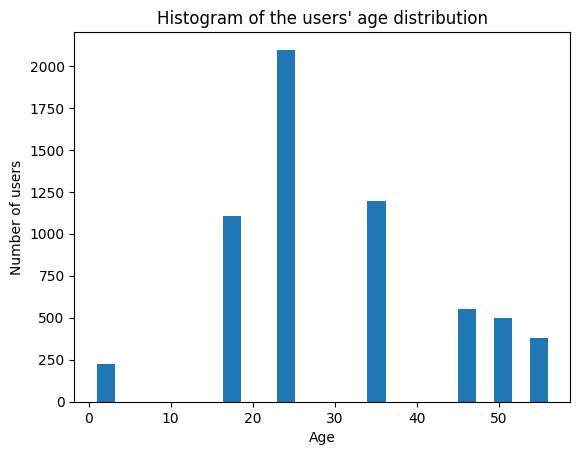

In [52]:
# Histogram of the user age distribution
df_users.age.plot.hist(bins=25)
plt.title("Histogram of the users' age distribution")
plt.ylabel('Number of users')
plt.xlabel('Age')
plt.show()

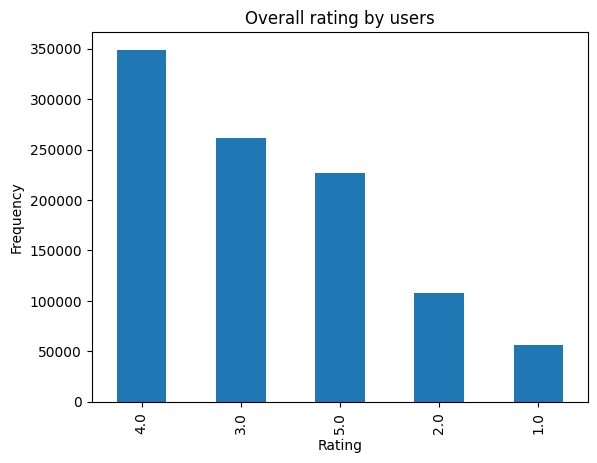

In [53]:
# Visualize overall rating by users
df['rating'].value_counts().plot(kind='bar')
plt.title("Overall rating by users")
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.show()

In [54]:
# Aggregate the data by movie title
agg_ratings = df.groupby('title').agg(
    mean_rating = ('rating', 'mean'),  # Calculate the mean rating for each movie
    number_of_ratings = ('rating', 'count')  # Count the number of ratings for each movie
).reset_index()  # Reset the index after grouping

# Filter to keep only the movies with more than 50 ratings
agg_ratings_50 = agg_ratings[agg_ratings['number_of_ratings'] > 50]

# Display information about the filtered dataset
agg_ratings_50.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2499 entries, 1 to 3705
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2499 non-null   object 
 1   mean_rating        2499 non-null   float32
 2   number_of_ratings  2499 non-null   int64  
dtypes: float32(1), int64(1), object(1)
memory usage: 68.3+ KB


In [55]:
# Get most popular movies
agg_ratings_50.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
127,American Beauty (1999),4.317386,3428
3153,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
3154,Star Wars: Episode V - The Empire Strikes Back...,4.292976,2990
3155,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
1789,Jurassic Park (1993),3.763847,2672


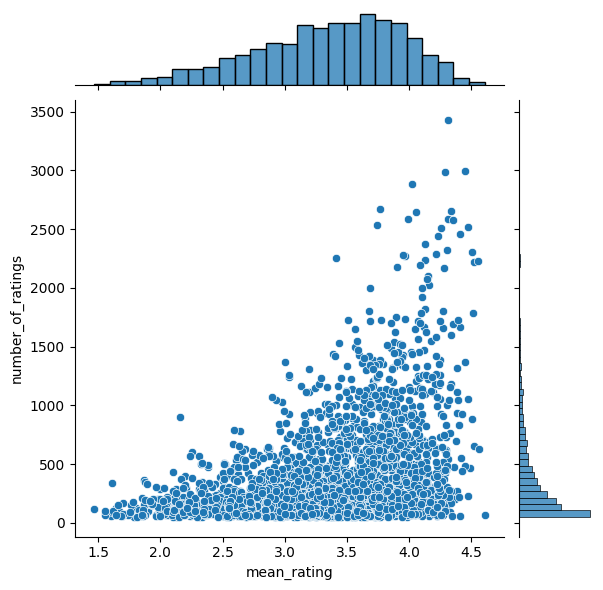

In [56]:
# Create and visualize a jointplot of mean rating vs number of ratings
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_50)

In [57]:
# Merge the original dataframe with the filtered dataframe of movies with more than 50 ratings
df_50 = pd.merge(df, agg_ratings_50[['title']], on='title', how='inner')

# Display information about the merged dataframe
df_50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977089 entries, 0 to 977088
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   977089 non-null  int32  
 1   movieId  977089 non-null  int32  
 2   rating   977089 non-null  float32
 3   title    977089 non-null  object 
 4   genres   977089 non-null  object 
dtypes: float32(1), int32(2), object(2)
memory usage: 26.1+ MB


In [58]:
# For Visualizations
evaluate = pd.DataFrame()

In [59]:
# Function to calculate the root mean squared error (RMSE)
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Task 1: User-based Collaborative Filtering

In [60]:
# Select a user ID
selected_userid1 = 4

# Define a list of K values to try for the knn model
K_values = [30, 29, 28, 31, 32]

In [61]:
# Create a user-item matrix where each row represents a user, each column represents a movie,
# and each cell represents the rating that the user gave to the movie
matrix1 = df_50.pivot_table(index='userId', columns='title', values='rating')

# Display the user-item matrix
matrix1.head()

title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Normalize the user-item matrix by subtracting the mean rating of each user from their ratings
matrix_norm1 = matrix1.subtract(matrix1.mean(axis=1), axis = 'rows')
matrix_norm1

title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.098039,0.098039,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.317479,NaN,NaN,NaN,-1.317479,0.682521,NaN,NaN,-2.317479,NaN,...,NaN,NaN,0.682521,NaN,NaN,NaN,-0.317479,NaN,NaN,-1.317479
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# User similarity correlation
user_matrix_norm = matrix_norm1.T.corr()
user_matrix_norm

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.416667,-3.321819e-01,0.333333,-0.172516,0.219956,NaN,-0.583333,3.305715e-01,-0.057363,...,-1.601282e-01,7.559289e-01,1.000000,NaN,0.381246,-0.201132,-4.517540e-01,NaN,0.056857,-0.043519
2,0.416667,1.000000,2.368339e-01,-0.118678,-0.208333,-0.061859,0.154303,0.024968,2.051123e-01,-0.091578,...,-7.092994e-01,9.083405e-02,0.301309,NaN,0.390907,0.377852,3.081451e-01,-0.500000,0.572078,-0.027143
3,-0.332182,0.236834,1.000000e+00,0.840168,-0.437621,-0.349215,0.790569,-0.528594,-4.807407e-17,0.009305,...,-3.952847e-01,-9.759001e-02,-0.711556,NaN,0.427001,0.204619,1.065328e-17,0.500000,0.309277,-0.395285
4,0.333333,-0.118678,8.401681e-01,1.000000,0.000000,NaN,-0.207514,0.534522,5.222330e-01,-0.270501,...,-6.454972e-01,2.266233e-17,-0.078598,NaN,-0.013558,0.467447,-1.132277e-01,-1.000000,0.000000,0.450323
5,-0.172516,-0.208333,-4.376208e-01,0.000000,1.000000,-0.592014,-0.028516,0.218130,-1.538216e-17,-0.023582,...,2.608746e-01,7.071068e-01,0.116775,0.500000,0.539112,0.159615,-9.713482e-02,-0.928571,1.000000,0.308273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.201132,0.377852,2.046187e-01,0.467447,0.159615,-0.318681,0.383365,0.289044,7.021107e-02,0.055250,...,1.039315e-02,2.435350e-01,0.286357,0.608581,0.368975,1.000000,1.708959e-01,-0.118345,0.186261,0.359431
6037,-0.451754,0.308145,1.065328e-17,-0.113228,-0.097135,-0.272166,-0.095433,-0.102564,2.540423e-01,-0.015117,...,-7.817023e-17,2.430949e-01,-0.129641,0.165395,0.333667,0.170896,1.000000e+00,-1.000000,0.129522,0.165982
6038,NaN,-0.500000,5.000000e-01,-1.000000,-0.928571,-0.866025,NaN,NaN,8.703883e-01,0.731792,...,-6.324555e-01,1.961161e-01,1.000000,NaN,0.500000,-0.118345,-1.000000e+00,1.000000,0.271163,-0.397122


In [64]:
# Fill NaN values in the normalized user-user matrix with 0
user_matrix_norm = user_matrix_norm.fillna(0)

In [65]:
# Retrieve the movies that the selected user has watched
selected_userid_watched1 = matrix1[matrix1.index == selected_userid1].dropna(axis=1, how='all')
selected_userid_watched1

title,Alien (1979),Die Hard (1988),E.T. the Extra-Terrestrial (1982),"Fistful of Dollars, A (1964)",Goldfinger (1964),"Good, The Bad and The Ugly, The (1966)","Hustler, The (1961)",Jaws (1975),Jurassic Park (1993),King Kong (1933),...,Predator (1987),Raiders of the Lost Ark (1981),Rocky (1976),Run Lola Run (Lola rennt) (1998),Saving Private Ryan (1998),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),"Terminator, The (1984)",Thelma & Louise (1991)
userId,,,,,,,,,,,,,,,,,,,,,
4,4.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,4.0,4.0,...,1.0,5.0,5.0,5.0,5.0,5.0,2.0,3.0,5.0,4.0


In [66]:
# Define the number of similar users to find
k1 = 10

KNNCF = 30

# Create a k-nearest neighbors (knn) model object
# The 'correlation' metric is used to measure similarity between users
knn1 = NearestNeighbors(n_neighbors=(k1+1), metric='correlation', algorithm='brute')

# Fit the knn model
knn1.fit(user_matrix_norm.values)

def user_based_collaborative_filtering(selected_userid1):
    # Use the knn model to find the nearest neighbors for the selected user
    distances1, indices1 = knn1.kneighbors(
        user_matrix_norm.loc[selected_userid1].values.reshape(1, -1), 
        return_distance=True
    )

    # Exclude the first index because it is the selected user themselves
    indices1 = indices1[0][1:]
    distances1 = distances1[0][1:]

    # Retrieve the IDs of the top n similar users
    similar_users = matrix_norm1.index[indices1.flatten()]

    # Print out the IDs of the top n similar users and their corresponding distances from the selected user
    print(f'The similar users for user {selected_userid1} are', similar_users, distances1, '\n')

    # Retrieve the movies that the similar users have watched
    # Remove the columns (movies) that all similar users have not watched (NaN values)
    similar_user_movies = matrix_norm1[matrix_norm1.index.isin(similar_users)].dropna(axis=1, how='all')

    # Create a DataFrame to store the scores for each movie
    item_score = pd.DataFrame(columns=['movie', 'movie_score'])

    # Loop through each movie in the similar users' movie list
    for i in similar_user_movies.columns:
        # Get the ratings given by similar users for movie i
        movie_rating = similar_user_movies[i]

        # Initialize variables to store the total score and count of scores for movie i
        total = 0
        count = 0

        # Loop through each similar user
        for idx, u in enumerate(similar_users):
            # If the user has rated movie i
            if pd.isna(movie_rating[u]) == False:
                # Calculate the score for movie i from this user, which is the product of the user's similarity to the picked user and their rating for movie i
                score = distances1[idx] * movie_rating[u]

                # Add this score to the total score for movie i
                total += score

                # Increment the count of scores for movie i
                count +=1

        # Calculate the average score for movie i (total score divided by count of scores) and add it to the DataFrame
        # If no similar user has rated movie i (count is zero), then its average score is set as NaN
        item_score = pd.concat(
            [item_score, 
             pd.DataFrame({'movie': [i], 'movie_score': [total / count if count > 0 else np.nan]})],
            ignore_index=True
        )


    # Sort the movies by their scores in descending order
    ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
    print(ranked_item_score, '\n')

    # Calculate the average rating given by the picked user
    avg_rating = matrix1[matrix1.index == selected_userid1].T.mean()[selected_userid1]

    # Print the average movie rating for the picked user
    print(f'The average movie rating for user {selected_userid1} is {avg_rating:.2f}\n')

    # Calculate the predicted rating for each movie by adding the average rating of the picked user to the movie's score
    ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating
    
    return ranked_item_score

In [67]:
pred = user_based_collaborative_filtering(selected_userid1)

The similar users for user 4 are Index([446, 489, 5332, 4030, 3535, 4649, 5712, 4853, 2159, 2336], dtype='int32', name='userId') [0.67191943 0.70874544 0.73404155 0.74618908 0.74949569 0.75129996
 0.75520532 0.75554349 0.76268029 0.76394516] 

                                                 movie  movie_score
20                               Apocalypse Now (1979)     1.181242
17   And Now for Something Completely Different (1971)     1.181242
263                                Pulp Fiction (1994)     1.181242
305                             Sixteen Candles (1984)     1.143354
304                              Simple Plan, A (1998)     1.143354
..                                                 ...          ...
349                                Urban Legend (1998)    -1.653739
143     Godzilla 2000 (Gojira ni-sen mireniamu) (1999)    -1.653739
167                         Highlander: Endgame (2000)    -1.653739
85                                  Deep Impact (1998)    -2.493730
272  Ret

In [68]:
pred

,movie,movie_score,predicted_rating
20,Apocalypse Now (1979),1.181242,5.371719
17,And Now for Something Completely Different (1971),1.181242,5.371719
263,Pulp Fiction (1994),1.181242,5.371719
305,Sixteen Candles (1984),1.143354,5.333831
304,"Simple Plan, A (1998)",1.143354,5.333831
...,...,...,...
349,Urban Legend (1998),-1.653739,2.536737
143,Godzilla 2000 (Gojira ni-sen mireniamu) (1999),-1.653739,2.536737
167,Highlander: Endgame (2000),-1.653739,2.536737
85,Deep Impact (1998),-2.493730,1.696746


In [102]:
# Create a DataFrame to store the results for each K value
user_rmse = pd.DataFrame(columns=['K', 'RMSE'])

# Loop through each K value
for K in K_values:
    # Create a knn model object with the desired parameters
    knn1 = NearestNeighbors(n_neighbors=(K+1), metric='correlation', algorithm='brute')

    # Fit the knn model on the user-item matrix
    knn1.fit(user_matrix_norm.values)

    # Find the nearest neighbors for the selected user
    distances1, indices1 = knn1.kneighbors(
        user_matrix_norm.loc[selected_userid1].values.reshape(1, -1),
        return_distance=True
    )

    # Exclude the first index because it is the selected user themselves
    indices1 = indices1[0][1:]
    distances1 = distances1[0][1:]

    # Retrieve the IDs of the top K similar users
    similar_users = matrix_norm1.index[indices1.flatten()]

    # Retrieve the movies that the similar users have watched and remove movies that none of them have watched
    similar_user_movies = matrix_norm1[matrix_norm1.index.isin(similar_users)].dropna(axis=1, how='all')
    
    # Create a DataFrame to store the scores for each movie
    item_score = pd.DataFrame(columns=['movie', 'movie_score'])

    # Loop through each movie in the similar users' movie list
    for i in similar_user_movies.columns:
        # Get the ratings given by similar users for movie i
        movie_rating = similar_user_movies[i]
        
        # Initialize variables to store the total score and count of scores for movie i
        total = 0
        count = 0
        
        # Loop through each similar user
        for idx, u in enumerate(similar_users):
            # If the user has rated movie i
            if pd.isna(movie_rating[u]) == False:
                # Calculate the score for movie i from this user, which is the product of the user's similarity to the picked user and their rating for movie i
                score = distances1[idx] * movie_rating[u]
                
                # Add this score to the total score for movie i
                total += score
                
                # Increment the count of scores for movie i
                count +=1
                
        # Calculate the average score for movie i (total score divided by count of scores) and add it to the DataFrame
        # If no similar user has rated movie i (count is zero), then its average score is set as NaN
        item_score = pd.concat(
            [item_score, 
             pd.DataFrame({'movie': [i], 'movie_score': [total / count if count > 0 else np.nan]})],
            ignore_index=True
        )

    # Calculate the average rating given by the picked user
    avg_rating = matrix1[matrix1.index == selected_userid1].T.mean()[selected_userid1]
    
    # Sort the movies by their scores in descending order and calculate predicted rating by adding average rating of picked user to movie's score
    ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
    ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating
    
    # Print the average movie rating for user with K value
    print(f'The average movie rating for user {selected_userid1} is {avg_rating:.2f} with K = {K}')
  
    # Find movies that both picked user and similar users have watched and have a predicted rating
    common_movies = list(set(selected_userid_watched1.columns) & set(ranked_item_score['movie']))

    # Get actual ratings given by picked user for common movies
    actual_ratings = selected_userid_watched1.loc[selected_userid1, common_movies].values.flatten()

    # Get predicted ratings for common movies based on similar users' ratings
    predicted_ratings = ranked_item_score.loc[
        ranked_item_score['movie'].isin(common_movies),
        'predicted_rating'
    ].values.flatten()
    
    # Calculate RMSE between actual and predicted ratings and add it to results DataFrame with K value
    user_rmse = pd.concat(
        [user_rmse, 
         pd.DataFrame({'K': [K], 'RMSE': [rmse(actual_ratings, predicted_ratings)]})],
        ignore_index=True
    )
    
    # Binarize the ratings by setting a threshold value
    threshold = 3
    y_true_binary = np.where(actual_ratings >= threshold, 1, 0)
    y_scores_binary = np.where(predicted_ratings >= threshold, 1, 0)
    
    # Calculate AP
    ap = average_precision_score(y_true_binary, y_scores_binary)
    print(f'Average Precision: {ap}')
    
    # Calculate NDCG
    ndcg = ndcg_score([actual_ratings], [predicted_ratings])
    print(f'Normalized Discounted Cumulative Gain: {ndcg}\n')

# Sort results by RMSE in ascending order and display them
user_rmse.sort_values(by='RMSE')

The average movie rating for user 4 is 4.19 with K = 30
Average Precision: 0.9047619047619048
Normalized Discounted Cumulative Gain: 0.956177310098027

The average movie rating for user 4 is 4.19 with K = 29
Average Precision: 0.9047619047619048
Normalized Discounted Cumulative Gain: 0.956177310098027

The average movie rating for user 4 is 4.19 with K = 28
Average Precision: 0.9047619047619048
Normalized Discounted Cumulative Gain: 0.956177310098027

The average movie rating for user 4 is 4.19 with K = 31
Average Precision: 0.9047619047619048
Normalized Discounted Cumulative Gain: 0.956177310098027

The average movie rating for user 4 is 4.19 with K = 32
Average Precision: 0.9047619047619048
Normalized Discounted Cumulative Gain: 0.956177310098027



,K,RMSE
4,32,1.091461
1,29,1.101757
2,28,1.105985
0,30,1.107429
3,31,1.109498


In [103]:
# Add AP of User-based to evaluate df
evaluate.loc['User-based', 'AP'] = ap
# Add NDCG of User-based to evaluate df
evaluate.loc['User-based', 'NDCG'] = ndcg

In [71]:
evaluate

,AP,NDCG
User-based,0.904762,0.956177


# Task 2: Item-based Filtering

In [72]:
# Pick a user ID
selected_userid2 = 10

# Pick a movie
selected_movie = "Young Poisoner's Handbook, The (1995)"

# Define the similarity metrics to compare
similarity_metrics = ['correlation', 'cosine']

In [73]:
# Create a item-user matrix where each row represents a movie, each column represents a user,
# and each cell represents the rating that the user gave to the movie
matrix2 = df_50.pivot_table(index='title', columns='userId', values='rating')

# Display the item-user matrix
matrix2.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
title,,,,,,,,,,,,,,,,,,,,,
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN


In [74]:
# Normalize the item-user matrix by subtracting the mean rating of each user from their ratings
matrix_norm2 = matrix2.subtract(matrix2.mean(axis=1), axis = 'rows')
matrix_norm2

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
title,,,,,,,,,,,,,,,,,,,,,
'Night Mother (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.371428,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'burbs, The (1989)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.089109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...And Justice for All (1979),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.422857,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Young Poisoner's Handbook, The (1995)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Young Sherlock Holmes (1985),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.390501,NaN,NaN,-0.390501,NaN
Your Friends and Neighbors (1998),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# Item similarity correlation
item_matrix_norm = matrix_norm2.T.corr()
item_matrix_norm

title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
title,,,,,,,,,,,,,,,,,,,,,
'Night Mother (1986),1.000000,-0.177705,0.240000,0.216272,2.661576e-01,0.220347,-0.199239,0.213733,-0.365042,NaN,...,0.517853,-0.010768,0.182495,0.256130,0.196419,7.745967e-01,-0.276359,-0.052758,0.082580,0.100372
'Til There Was You (1997),-0.177705,1.000000,0.712627,0.719676,3.002731e-01,0.457984,0.564288,0.210259,0.358464,NaN,...,0.597842,0.158114,0.384134,-0.040379,0.138409,NaN,-0.016137,0.059235,0.183855,0.303731
"'burbs, The (1989)",0.240000,0.712627,1.000000,0.089727,1.896894e-01,0.088541,0.101064,0.047590,0.096866,-6.855612e-02,...,0.298285,0.391559,0.041385,0.376289,0.456148,3.556541e-01,0.278425,0.158997,0.039503,0.135172
...And Justice for All (1979),0.216272,0.719676,0.089727,1.000000,2.911245e-01,0.166965,-0.142597,0.303093,0.161660,3.535534e-01,...,0.023602,0.417406,0.154534,-0.068832,0.039039,-2.792572e-01,0.052517,0.159503,0.200237,-0.024037
10 Things I Hate About You (1999),0.266158,0.300273,0.189689,0.291124,1.000000e+00,0.163892,0.372055,0.101730,0.266755,1.806786e-01,...,0.194905,-0.080218,0.116762,0.321472,0.200233,-1.088663e-17,0.185754,-0.176618,0.199307,0.022365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Young Poisoner's Handbook, The (1995)",0.774597,NaN,0.355654,-0.279257,-1.088663e-17,0.100529,-0.174078,0.057011,-0.459667,NaN,...,-0.111396,0.263822,0.009236,-0.100828,0.039311,1.000000e+00,-0.169526,0.567775,0.106987,-0.034653
Young Sherlock Holmes (1985),-0.276359,-0.016137,0.278425,0.052517,1.857543e-01,0.013905,0.059504,0.281127,0.231933,9.705232e-02,...,-0.042358,0.480275,0.154235,0.250146,0.412327,-1.695258e-01,1.000000,-0.173220,0.089512,0.153340
Your Friends and Neighbors (1998),-0.052758,0.059235,0.158997,0.159503,-1.766175e-01,0.148548,0.124035,0.025703,-0.195237,0.000000e+00,...,-0.084022,0.327355,0.169951,-0.178344,-0.247993,5.677750e-01,-0.173220,1.000000,0.064367,0.373099


In [76]:
# Fill NaN values in the normalized item-item matrix with 0
item_matrix_norm = item_matrix_norm.fillna(0)

In [77]:
# Get the movies that the target user has watched
selected_userid_watched2 = (
    pd.DataFrame(
        # Get the ratings of the movies watched by the target user
        # Drop any rows with all NaN values and sort in descending order
        matrix_norm2[selected_userid2].dropna(axis=0, how='all').sort_values(ascending=False)
    )
    .reset_index()
    .rename(columns={selected_userid2: 'rating'})
)

# Display
selected_userid_watched2

,title,rating
0,Lost in Space (1998),2.415292
1,Battlefield Earth (2000),2.388889
2,Mr. Saturday Night (1992),2.288136
3,Houseguest (1994),2.086957
4,"First Wives Club, The (1996)",2.047458
...,...,...
391,Tora! Tora! Tora! (1970),-1.701031
392,Chasing Amy (1997),-1.778468
393,Clerks (1994),-1.946884
394,"Affair to Remember, An (1957)",-1.952381


In [78]:
# Define the number of similar items to find
k2 = 500

# Create a k-nearest neighbors (knn) model object
# The 'correlation' metric is used to measure similarity between items
knn2 = NearestNeighbors(n_neighbors=(k2+1), metric='correlation', algorithm='brute')

# Fit the knn model
knn2.fit(item_matrix_norm.values)

# Use the knn model to find the nearest neighbors for the picked movie
distances2, indices2 = knn2.kneighbors(
    item_matrix_norm.loc[selected_movie].values.reshape(1, -1), 
    return_distance=True
)

# Flatten the distances array and remove the given item
similar_movies_distances = distances2.flatten()[1:]

# Get the indices of the k most similar movies
similar_movies_indices = indices2.flatten()[1:]

# Get the titles of the similar movies
similar_movies_titles = item_matrix_norm.index[similar_movies_indices]

In [79]:
# Create a DataFrame
similar_movies = pd.DataFrame({
    'title': similar_movies_titles,
    'similarity_score': similar_movies_distances
})

n = 10
# Merge and rank the similarities between the movies target user has rated and picked movie
selected_user_watched_similar = (
    pd.merge(
        # Get the ratings of the movies watched by the target user
        left=selected_userid_watched2, 
        # Get the similarity scores of the movies similar to the picked movie
        right=similar_movies, 
        on='title', 
        how='inner')
    # Sort by similarity score in descending order and select top n movies
    .sort_values('similarity_score', ascending=False)[:n]
)

# Display
selected_user_watched_similar

,title,rating,similarity_score
66,Buffy the Vampire Slayer (1992),-0.091797,0.960538
35,Cat on a Hot Tin Roof (1958),0.952030,0.960191
20,"Dark Crystal, The (1982)",1.347887,0.959658
75,Rear Window (1954),-0.476191,0.959537
78,Austin Powers: International Man of Mystery (1...,-0.710373,0.959340
74,Pee-wee's Big Adventure (1985),-0.405343,0.959255
67,Bonnie and Clyde (1967),-0.096210,0.958358
6,What About Bob? (1991),1.602203,0.958279
16,Grease (1978),1.422277,0.958154
39,My Fair Lady (1964),0.845912,0.958048


In [80]:
# Calculate the predicted rating using a weighted average of similarity scores and the ratings from the target user
predicted_rating = round(
    np.average(
        selected_user_watched_similar['rating'], 
        weights=selected_user_watched_similar['similarity_score']
    ), 8
)

# Print the predicted rating for the selected movie by the selected user
print(f'The predicted rating for {selected_movie} by user {selected_userid2} is {predicted_rating}')


The predicted rating for Young Poisoner's Handbook, The (1995) by user 10 is 0.43878734


In [98]:
# Define the number of similar items to find
K = 500

# Initialize a dictionary to store the RMSE for each metric
item_rmse = {}

# Loop through each similarity metric
for metric in similarity_metrics:
    # Create a knn model using the current similarity metric
    knn2 = NearestNeighbors(n_neighbors=(K+1), metric=metric, algorithm='brute')

    # Fit the knn model with the normalized item matrix
    knn2.fit(item_matrix_norm.values)

    # Use the knn model to find the nearest neighbors for the picked movie
    distances2, indices2 = knn2.kneighbors(
        item_matrix_norm.loc[selected_movie].values.reshape(1, -1), 
        return_distance=True
    )

    # Get the indices of the k most similar movies
    similar_movies_indices = indices2.flatten()[1:]

    # Get the titles of the similar movies
    similar_movies_titles = item_matrix_norm.index[similar_movies_indices]

    # Create a DataFrame with the titles and similarity scores of the similar movies
    similar_movies = pd.DataFrame({
        'title': similar_movies_titles,
        'similarity_score': distances2.flatten()[1:]
    })

    # Merge and rank the similarities between the movies that the target user has rated and the picked movie
    selected_user_watched_similar = (
        pd.merge(
            left=selected_userid_watched2, 
            right=similar_movies, 
            on='title', 
            how='inner')
        .sort_values('similarity_score', ascending=False)[:n]
    )

    # Calculate the predicted rating using weighted average of similarity scores and the ratings from target user
    predicted_rating = np.average(
        selected_user_watched_similar['rating'], 
        weights=selected_user_watched_similar['similarity_score']
    )
    
    # Print the predicted rating for the selected movie by the selected user using the current similarity metric
    print(f'Using {metric} as a metric, The predicted rating for {selected_movie} by user {selected_userid2} is {predicted_rating}')
   
    # Calculate the RMSE between the predicted rating and average rating of the target user
    score = rmse([selected_userid_watched2['rating'].mean()], [predicted_rating])

    # Store the RMSE score for this similarity metric in the dictionary
    item_rmse[metric] = score
    
    # Binarize the ratings and convert them into arrays of the same length as predicted_ratings
    y_true_binary = np.repeat(np.array(y_true_binary), len(predicted_ratings))
    y_scores_binary = np.repeat(np.array(y_scores_binary), len(predicted_ratings))
    
    # Calculate AP
    ap = average_precision_score(y_true_binary, y_scores_binary)
    print(f'Average Precision: {ap}')
    
    # Calculate NDCG
    ndcg = ndcg_score([actual_ratings], [predicted_ratings])
    print(f'Normalized Discounted Cumulative Gain: {ndcg}\n')

# Print the dictionary of RMSE scores for each similarity metric
print(item_rmse)

'eXistenZ (1999)'

In [96]:
# Add AP of Item-based to evaluate df
evaluate.loc['Item-based', 'AP'] = ap
# Add NDCG of Item-based to evaluate df
evaluate.loc['Item-based', 'NDCG'] = ndcg

In [97]:
evaluate

,AP,NDCG
User-based,0.904762,0.956177
Item-based,0.890345,0.920235


# Task 3: Better Recommender System

In [84]:
# Select a user ID
selected_userid = 4

In [85]:
# Create user-item matrix
mat = df_50.pivot_table(index='userId', columns='title', values='rating')
mat.head()

title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Normalize user-item matrix
matrix_norm = mat.subtract(mat.mean(axis=1), axis = 'rows')
matrix_norm

title,'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),"13th Warrior, The (1999)",187 (1997),...,You've Got Mail (1998),Young Doctors in Love (1982),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Your Friends and Neighbors (1998),Zero Effect (1998),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.098039,0.098039,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.317479,NaN,NaN,NaN,-1.317479,0.682521,NaN,NaN,-2.317479,NaN,...,NaN,NaN,0.682521,NaN,NaN,NaN,-0.317479,NaN,NaN,-1.317479
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()

In [88]:
# Remove picked user ID from the candidate list
user_similarity.drop(index=selected_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.416667,-0.332182,0.333333,-0.172516,0.219956,NaN,-0.583333,3.305715e-01,-0.057363,...,-0.160128,0.755929,1.000000,NaN,0.381246,-0.201132,-4.517540e-01,NaN,0.056857,-0.043519
2,0.416667,1.000000,0.236834,-0.118678,-0.208333,-0.061859,0.154303,0.024968,2.051123e-01,-0.091578,...,-0.709299,0.090834,0.301309,NaN,0.390907,0.377852,3.081451e-01,-0.500000,0.572078,-0.027143
3,-0.332182,0.236834,1.000000,0.840168,-0.437621,-0.349215,0.790569,-0.528594,-4.807407e-17,0.009305,...,-0.395285,-0.097590,-0.711556,NaN,0.427001,0.204619,1.065328e-17,0.500000,0.309277,-0.395285
5,-0.172516,-0.208333,-0.437621,0.000000,1.000000,-0.592014,-0.028516,0.218130,-1.538216e-17,-0.023582,...,0.260875,0.707107,0.116775,0.5,0.539112,0.159615,-9.713482e-02,-0.928571,1.000000,0.308273
6,0.219956,-0.061859,-0.349215,NaN,-0.592014,1.000000,0.866025,-0.590932,-2.374290e-01,0.324967,...,-0.693375,0.806226,NaN,NaN,-0.385922,-0.318681,-2.721655e-01,-0.866025,-0.464973,0.056622


In [89]:
# Number of similar users
n = 10

# User similarity threashold
threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[selected_userid] > threshold][selected_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {selected_userid} are', similar_users)

The similar users for user 4 are userId
2738    1.0
3832    1.0
3694    1.0
1315    1.0
5943    1.0
1286    1.0
3759    1.0
1275    1.0
1263    1.0
3814    1.0
Name: 4, dtype: float64


In [90]:
# Movies that the selected user has watched
watched = matrix_norm[matrix_norm.index == selected_userid].dropna(axis=1, how='all')
watched

title,Alien (1979),Die Hard (1988),E.T. the Extra-Terrestrial (1982),"Fistful of Dollars, A (1964)",Goldfinger (1964),"Good, The Bad and The Ugly, The (1966)","Hustler, The (1961)",Jaws (1975),Jurassic Park (1993),King Kong (1933),...,Predator (1987),Raiders of the Lost Ark (1981),Rocky (1976),Run Lola Run (Lola rennt) (1998),Saving Private Ryan (1998),Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),"Terminator, The (1984)",Thelma & Louise (1991)
userId,,,,,,,,,,,,,,,,,,,,,
4,-0.190476,-0.190476,-0.190476,-0.190476,0.809524,0.809524,0.809524,0.809524,-0.190476,-0.190476,...,-3.190476,0.809524,0.809524,0.809524,0.809524,0.809524,-2.190476,-1.190476,0.809524,-0.190476


In [91]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')

In [92]:
# Remove the watched movie from the movie list
similar_user_movies.drop(watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

title,10 Things I Hate About You (1999),12 Angry Men (1957),2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),"Addams Family, The (1991)","Adventures of Priscilla, Queen of the Desert, The (1994)","African Queen, The (1951)",Afterglow (1997),Airplane! (1980),Aladdin (1992),...,Wild Wild West (1999),Willy Wonka and the Chocolate Factory (1971),"Wizard of Oz, The (1939)",Wonder Boys (2000),"Wrong Trousers, The (1993)",X-Men (2000),Yojimbo (1961),You've Got Mail (1998),Young Frankenstein (1974),eXistenZ (1999)
userId,,,,,,,,,,,,,,,,,,,,,
1263,0.859712,NaN,NaN,-0.140288,-0.140288,NaN,NaN,NaN,0.859712,-1.140288,...,-2.140288,-1.140288,0.859712,NaN,1.859712,-1.140288,NaN,-1.140288,0.859712,-2.140288
1275,NaN,NaN,-0.482759,NaN,NaN,NaN,0.517241,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.507463,NaN,NaN,-0.492537
1315,NaN,NaN,0.494624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.505376,-0.505376,NaN,NaN,NaN,NaN,NaN,NaN
2738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.42,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3694,NaN,0.037736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3759,NaN,NaN,NaN,-0.009709,-0.009709,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.990291,NaN,NaN,NaN,NaN,NaN,0.990291,NaN
3814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.866667,NaN,NaN,-0.133333,NaN,NaN,NaN,NaN


In [93]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])
    
# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
343,Mallrats (1995),1.859712
410,Office Space (1999),1.859712
251,"Grand Day Out, A (1992)",1.859712
245,"Good Morning, Vietnam (1987)",1.859712
594,Wayne's World 2 (1993),1.859712
286,"Hurricane, The (1999)",1.859712
158,Dick (1999),1.859712
71,"Big Lebowski, The (1998)",1.859712
206,Fight Club (1999),1.709268
487,"Searchers, The (1956)",1.507463


In [94]:
# Average rating for the picked user
avg_rating = mat[mat.index == selected_userid].T.mean()[selected_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {selected_userid} is {avg_rating:.2f}')

The average movie rating for user 4 is 4.19


In [95]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
343,Mallrats (1995),1.859712,6.050189
410,Office Space (1999),1.859712,6.050189
251,"Grand Day Out, A (1992)",1.859712,6.050189
245,"Good Morning, Vietnam (1987)",1.859712,6.050189
594,Wayne's World 2 (1993),1.859712,6.050189
286,"Hurricane, The (1999)",1.859712,6.050189
158,Dick (1999),1.859712,6.050189
71,"Big Lebowski, The (1998)",1.859712,6.050189
206,Fight Club (1999),1.709268,5.899744
487,"Searchers, The (1956)",1.507463,5.697939


In [104]:
# Average rating for the picked user
avg_rating = mat[mat.index == selected_userid].T.mean()[selected_userid]

# Sort the movies by their scores in descending order and calculate predicted rating by adding average rating of picked user to movie's score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating
    
# Print the average movie rating for user 1
print(f'The average movie rating for user {selected_userid} is {avg_rating:.2f}')
  
# Find movies that both picked user and similar users have watched and have a predicted rating
common_movies = list(set(watched.columns) & set(ranked_item_score['movie']))

# Get actual ratings given by picked user for common movies
actual_ratings = watched.loc[selected_userid, common_movies].values.flatten()

# Get predicted ratings for common movies based on similar users' ratings
predicted_ratings = ranked_item_score.loc[
    ranked_item_score['movie'].isin(common_movies),
    'predicted_rating'
].values.flatten()

# Calculate AP
ap = average_precision_score(y_true_binary, y_scores_binary)
print(f'Average Precision: {ap}')

# Calculate NDCG
ndcg = ndcg_score([actual_ratings], [predicted_ratings])
print(f'Normalized Discounted Cumulative Gain: {ndcg}')

The average movie rating for user 4 is 4.19
Average Precision: 0.9047619047619048
Normalized Discounted Cumulative Gain: 0.2152048229709937


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1658: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(


In [112]:
# Add AP of Threshold-based to evaluate df
evaluate.loc['Threshold-based', 'AP'] = ap
# Add NDCG of Threshold-based to evaluate df
evaluate.loc['Threshold-based', 'NDCG'] = ndcg

In [113]:
evaluate

,AP,NDCG
User-based,0.904762,0.956177
Item-based,0.890345,0.920235
Threshold-based,0.972333,0.963425


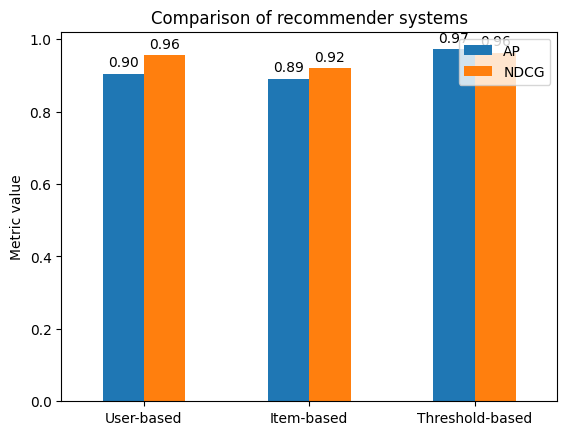

In [114]:
# Plot
ax = evaluate.plot.bar(rot=0)
ax.set_ylabel("Metric value")
ax.set_title("Comparison of recommender systems")

# Function to attach a text label above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate("{:.2f}".format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), # 3 points vertical offset
                    textcoords="offset points",
                    ha="center", va="bottom")

autolabel(ax.patches)

plt.show()